#Description
    Demultiplex RhizCG 150615_run2_rerun


#Setting variables

In [7]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150622_run2_rerun/'
seqDir = '/var/seq_data/RhizCG/150622_run2_rerun/raw/'

metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_run2.txt'
read1_file = 'read1.fq'
read2_file = 'read2.fq'
index_read1_file = 'Undetermined_S0_L001_I1_001.fastq'
index_read2_file = 'Undetermined_S0_L001_I2_001.fastq'
read12_screed_file = 'pear_merged-2015-06-27.assembled.fastq_screed'

#Init

In [8]:
import os
import screed
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from ggplot import *
import re
import scipy.stats as stats

In [9]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [10]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gdata)

In [12]:
#long processessing time
os.chdir(seqDir)
screed.read_fastq_sequences(index_read1_file)
screed.read_fastq_sequences(index_read2_file)

<ScreedDB, 'Undetermined_S0_L001_I2_001.fastq_screed'>

##Checkpoint: define index screed files to skip above step

In [26]:
os.chdir(seqDir)
index_read1_screed = index_read1_file + '_screed'
index_read2_screed = index_read2_file + '_screed'

#Demultiplex

In [27]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)

In [28]:
# loading/editing metadata

df_meta = pd.read_table(os.path.join(workDir,metadataFile), delimiter="\t")
df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]

## format of barcode=>sample dict: [revcomp(revBarcode=read1) + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [29]:
# loading screed databases 
os.chdir(seqDir)

ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed_file)

In [30]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed_file)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workDir, outFile)
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        # debug
        #c += 1
        #if c > 10000:
        #    break
            
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["accuracy"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print "Unable to assign %s reads to samples"%unassigned

Unable to assign 1489354 reads to samples


In [31]:
print outFile

/home/bryan/RhizCG/data/MiSeq_amplicon/150622_run2_rerun/pear_merged-2015-06-27.assembled.dmult.fastq


##Checkpoint: define outfile for next command without running above.

In [35]:
outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/150622_run2_rerun/pear_merged-2015-06-27.assembled.dmult.fastq'

In [36]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print 'Number of sequences: {}'.format(n_lines/4)

Number of sequences: 1606044


# Stats on sequences

## Number of sequences per sample

In [37]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [38]:
# converting to dataframe
df_seq_cnt = pd.DataFrame(seq_cnt.items(), columns=['Sample', 'seq_count'])
df_seq_cnt

,Sample,seq_count
0,sample8-3.28_Nneg,10178
1,sample8-1.06_Nneg,9153
2,sample6-4.13_Npos,8561
3,sample7-1.28_Npos,18741
4,sample6-2.05_Npos,21015
5,sample6-2.14_Npos,9083
6,sample7-3.19_Nneg,24778
7,sample8-1.14_Nneg,31614
8,sample7-3.12_Nneg,8149
9,sample8-2.17_Npos,13396


In [39]:
%%R -i workDir -i metadataFile -i df_seq_cnt

myDir = paste(c(workDir, '../'), collapse='')
setwd(myDir)


df_meta = read.delim(metadataFile)
df_meta %>% head %>% print

           X..sample Library Sample_Number Sample_Well_ID Primer_Number
1          Mock_comm       2            93            F12            93
2      Neg_Control_1       2            91            G12            91
3 Negative_Control_2       2            16            D11            16
4        Pos_Control       2            92            H12            92
5      Pos_Control_2       2            17            D12            17
6  sample1-1.06_Nneg       2             4             D1             4
  Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total barcode_ID    PlotID
1            F12                  94                94         94      <NA>
2            G12                  95                95         95      <NA>
3            D11                  84               180        180      <NA>
4            H12                  96                96         96      <NA>
5            D12                  92               188        188      <NA>
6             D1                   4    

In [40]:
%%R

tbl.cnt = inner_join(df_seq_cnt, df_meta, c('Sample' = 'X..sample'))
tbl.cnt %>% head

             Sample seq_count Library Sample_Number Sample_Well_ID
1 sample8-3.28_Nneg     10178       2            12            E10
2 sample8-1.06_Nneg      9153       2            46             A7
3 sample6-4.13_Npos      8561       2            69             H9
4 sample7-1.28_Npos     18741       2            15             G2
5 sample6-2.05_Npos     21015       2             6             F1
6 sample6-2.14_Npos      9083       2            65             D9
  Primer_Number Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total barcode_ID
1            12             E2                  13               109        109
2            46             A7                  49                49         49
3            69             H9                  72                72         72
4            15             G2                  15                15         15
5             6             F1                   6                 6          6
6            65             D9                  68 

In [41]:
%%R

tbl.cnt[10,] %>% print


              Sample seq_count Library Sample_Number Sample_Well_ID
10 sample8-2.17_Npos     13396       2            81            D11
   Primer_Number Primer_Well_ID primerFR_ID_byPlate primerFR_ID_total
10            81            D11                  84                84
   barcode_ID    PlotID Plant Plot Treatment Rep DAP Sampling  PlantSample
10         84 2.17_Npos  Mo18 2.17      Npos   2  88  sample8 Mo18 sample8
    Type Grass_Broad Status Subfamily fwd_barcode rev_barcode
10 Maize     Monocot   Crop  Paniceae    CTGCGTGT    TCATAGAC


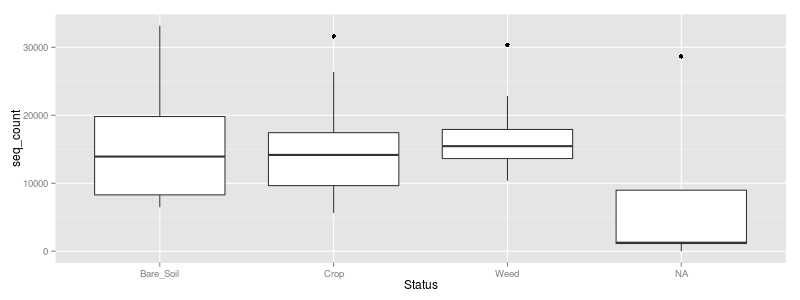

In [42]:
%%R -w 800 -h 300


ggplot(tbl.cnt, aes(Status, seq_count)) +
    geom_boxplot()